In [1]:
VERSION

v"1.7.0-DEV.1129"

In [2]:
using Test
using DifferentialEquations
using SimpleDiffEq
using Plots
using Elliptic

In [3]:
function my_RK4(f!, u0, tspan, p; dt=0.1)
    t = range(tspan...; step=dt)
    n = length(t)
    u = similar(typeof(u0)[], n)
    u[1] = u0
    du1, du2, du3, du4 = similar(u0), similar(u0), similar(u0), similar(u0)
    dt_half = dt/2
    for k in 2:n
        u_prev, t_prev = u[k-1], t[k-1]
        f!(du1, u_prev              , p, t_prev          )
        f!(du2, u_prev + du1*dt_half, p, t_prev + dt_half)
        f!(du3, u_prev + du2*dt_half, p, t_prev + dt_half)
        f!(du4, u_prev + du3*dt     , p, t_prev + dt     )
        u_next = @. u_prev + (du1 + 2du2 + 2du3 + du4)*dt/6
        u[k] = u_next
    end
    (; t, u)
end

my_RK4 (generic function with 1 method)

In [4]:
sn(u, k) = Jacobi.sn(u, k^2)
sol_exact(p, t) = ((g, l, ymax) = p; 2asin(ymax*sn(√(g/l)*t, ymax)))

function f!(du, u, p, t)
    g, l, = p
    du[1] = -(g/l)*sin(u[2])
    du[2] = u[1]
end

p = (g = 9.80665, l = 1.0, ymax = 0.999)
U0(p) = ((g, l, ymax) = p; [√(g/l)*2ymax, 0.0])
tspan = (0.0, 30.0)

(0.0, 30.0)

In [5]:
dt = 0.1
sol_fixedstep_RK4 = solve(ODEProblem(f!, U0(p), tspan, p), RK4(); adaptive=false, dt)
sol_SimpleRK4 = solve(ODEProblem(f!, U0(p), tspan, p), SimpleRK4(); dt)
sol_my_RK4 = my_RK4(f!, U0(p), tspan, p; dt)

@test sol_fixedstep_RK4.u ≈ sol_SimpleRK4.u ≈ sol_my_RK4.u

Test Passed

In [6]:
E(v, u, p, t) = ((g, l,) = p; v[1]^2/2 - (g/l)*(cos(u[1]) - 1))

function plot_pendulum(sol; title="solution: θ(t)")
    tspan, p = sol.prob.tspan, sol.prob.p
    t = range(tspan..., length=501)
    dθ = (t -> sol(t)[1]).(t)
    θ = (t -> sol(t)[2]).(t)
    θ_exact = sol_exact.(Ref(p), t)
    
    P = plot(t, [θ θ_exact]; label=["numerical" "exact"], ls=:auto, ylim=(-4, 6.5))
    plot!(xtick=0:2:30, ytick=-10:10)
    title!(title; titlefontsize=10)
    
    v0, u0 = first.((dθ, θ))
    E_exact = fill(E(v0, u0, p, 0.0), length(t))
    E_numerical = E.(dθ, θ, Ref(p), t)
    Q = plot(t, E_numerical - E_exact; label="")
    title!("total energy error"; titlefontsize=12)
    plot!(xtick=0:2:30)
    
    plot(P, Q; size=(800, 250), layout=(1, 2))
end

plot_pendulum (generic function with 1 method)

length(sol.t) = 301


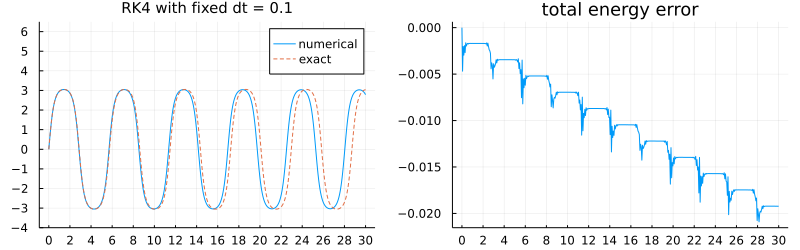

In [7]:
dt = 0.1
sol = solve(ODEProblem(f!, U0(p), tspan, p), RK4(); adaptive=false, dt)
@show length(sol.t)
plot_pendulum(sol; title="RK4 with fixed dt = $dt")

length(sol.t) = 3001


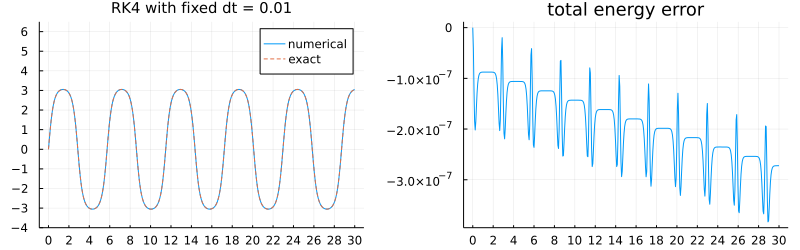

In [8]:
dt = 0.01
sol = solve(ODEProblem(f!, U0(p), tspan, p), RK4(); adaptive=false, dt)
@show length(sol.t)
plot_pendulum(sol; title="RK4 with fixed dt = $dt")

length(sol.t) = 287


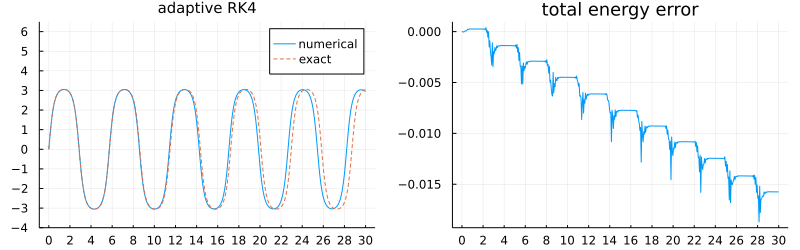

In [9]:
sol = solve(ODEProblem(f!, U0(p), tspan, p), RK4())
@show length(sol.t)
plot_pendulum(sol; title="adaptive RK4")

length(sol.t) = 3003


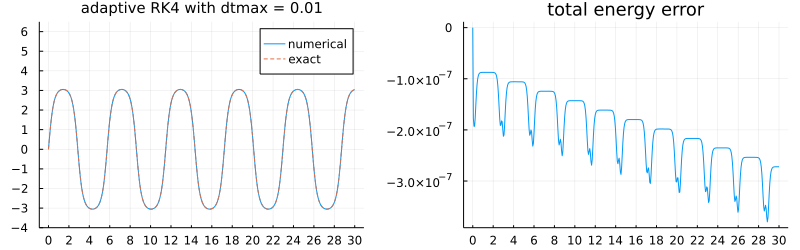

In [10]:
dtmax = 0.01
sol = solve(ODEProblem(f!, U0(p), tspan, p), RK4(); dtmax)
@show length(sol.t)
plot_pendulum(sol; title="adaptive RK4 with dtmax = $dtmax")

In [11]:
f1!(du, v, u, p, t) = ((g, l,) = p; du[1] = v[1])
f2!(dv, v, u, p, t) = ((g, l,) = p; dv[1] = -(g/l)*sin(u[1]))

h(v, u, p, t) = ((g, l,) = p; v[1]^2/2 - (g/l)*(cos(u[1]) + 1)) # Hamiltonian

v0(p) = ((g, l, ymax) = p; [√(g/l)*2ymax])
u0(p) = ((g, l, ymax) = p; [0.0])

u0 (generic function with 1 method)

length(sol.t) = 3003


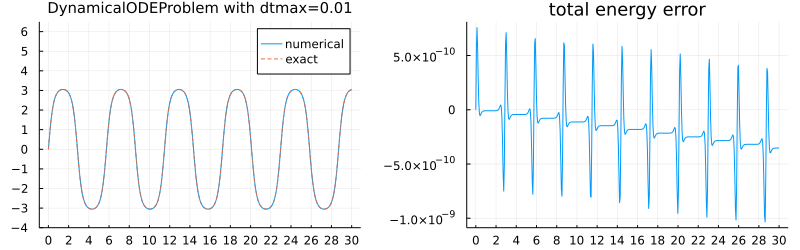

In [12]:
sol = solve(DynamicalODEProblem(f2!, f1!, v0(p), u0(p), tspan, p); dtmax=0.01)
@show length(sol.t)
plot_pendulum(sol; title="DynamicalODEProblem with dtmax=0.01")

length(sol.t) = 3003


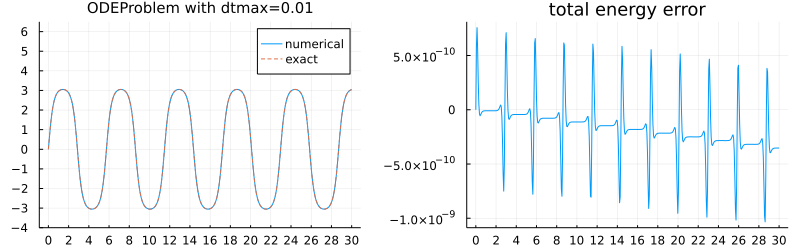

In [13]:
sol = solve(ODEProblem(f!, U0(p), tspan, p); dtmax=0.01)
@show length(sol.t)
plot_pendulum(sol; title="ODEProblem with dtmax=0.01")

length(sol.t) = 3003


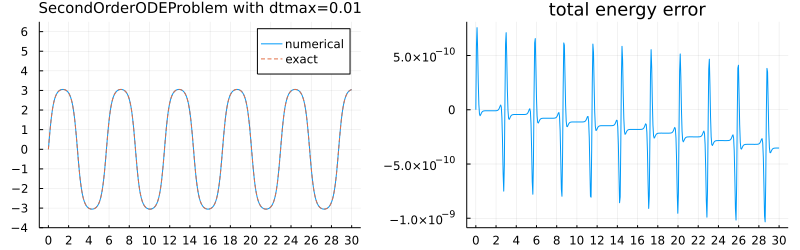

In [14]:
sol = solve(SecondOrderODEProblem(f2!, v0(p), u0(p), tspan, p); dtmax=0.01)
@show length(sol.t)
plot_pendulum(sol; title="SecondOrderODEProblem with dtmax=0.01")

length(sol.t) = 3003


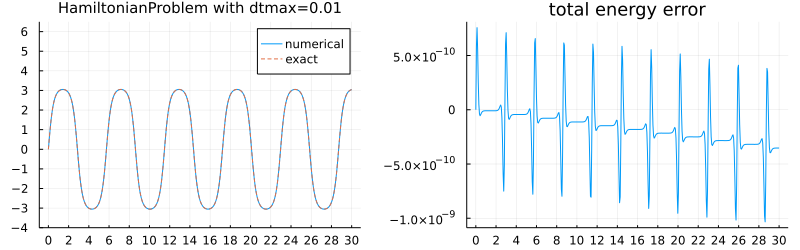

In [15]:
sol = solve(HamiltonianProblem(h, v0(p), u0(p), tspan, p); dtmax=0.01)
@show length(sol.t)
plot_pendulum(sol; title="HamiltonianProblem with dtmax=0.01")